# Modelo de Datos panel para proyecciones de Energía y Monto de Centrales Eléctricas

In [108]:
!pip install linearmodels pandas

In [109]:
import pandas as pd
import numpy as np
from datetime import date

import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

from linearmodels.panel import PanelOLS, PooledOLS
from linearmodels.iv.results import IVResults

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy.linalg as la
from scipy import stats
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Obtención de Dataset

In [110]:
#path = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/EnergiaMontos_CE_17-24_NoOutliers.csv'
path = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/EnergiaMontos_CE_17-24_Zscore.csv'
path_pred_input = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/Insumos_proyecciones/InsumosProyecciones_24-30_Zscore.csv'

In [111]:
df = pd.read_csv(path)

df_input = pd.read_csv(path_pred_input)

print(df.info())
print(df.shape)

print('Dimension datos de entrada para proyecciones')
print(df_input.info())
print(df_input.shape)


df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18954 entries, 0 to 18953
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FECHA            18954 non-null  object 
 1   FECHA_STRING     18954 non-null  object 
 2   ANIO             18954 non-null  int64  
 3   MES              18954 non-null  int64  
 4   CLV_CENTRAL      18954 non-null  object 
 5   TIPO_TEC         18954 non-null  object 
 6   PML_MTR          18954 non-null  float64
 7   E_FORECAST       18954 non-null  float64
 8   ENERGIA_PROM     18954 non-null  float64
 9   MONTO_PROM       18954 non-null  float64
 10  Z_SCORE_ENERGIA  18954 non-null  float64
 11  Z_SCORE_MONTO    18954 non-null  float64
 12  Z_ENERGIA_PROM   18954 non-null  float64
 13  Z_MONTO_PROM     18954 non-null  float64
 14  ENERGIA          18954 non-null  float64
 15  MONTO_NETO       18954 non-null  float64
 16  ENERGIA_ORI      18954 non-null  float64
 17  MONTO_ORI   

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,E_FORECAST,ENERGIA_PROM,MONTO_PROM,Z_SCORE_ENERGIA,Z_SCORE_MONTO,Z_ENERGIA_PROM,Z_MONTO_PROM,ENERGIA,MONTO_NETO,ENERGIA_ORI,MONTO_ORI
0,01/01/17,2017-01-01,2017,1,CCM,CC,1178.37,0.021,299226.9576,3.032824e+08,-0.9857,-0.5466,0.7169,0.6831,214765.105247,1.467179e+08,214765.105247,1.467179e+08
1,01/02/17,2017-02-01,2017,2,CCM,CC,471.01,0.021,299226.9576,3.032824e+08,-1.2639,-0.7671,0.7169,0.6831,190920.959000,8.356557e+07,190920.959000,8.356557e+07
2,01/03/17,2017-03-01,2017,3,CCM,CC,469.39,0.021,299226.9576,3.032824e+08,-0.8310,-0.6852,0.7169,0.6831,228021.836000,1.070203e+08,228021.836000,1.070203e+08
3,01/04/17,2017-04-01,2017,4,CCM,CC,500.65,0.021,299226.9576,3.032824e+08,-1.0279,-0.6944,0.7169,0.6831,211149.651000,1.043943e+08,211149.651000,1.043943e+08
4,01/05/17,2017-05-01,2017,5,CCM,CC,556.09,0.021,299226.9576,3.032824e+08,-0.3350,-0.5710,0.7169,0.6831,270517.863000,1.397430e+08,270517.863000,1.397430e+08


In [112]:
df_input.head()

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC
0,01/01/24,2024-01-01,2024,1,CCM,CC,934.03,221586.2693,2.177497e+08,0.021,226239.5810,2.223224e+08
1,01/02/24,2024-02-01,2024,2,CCM,CC,704.44,240332.3243,2.024711e+08,0.021,245379.3031,2.067230e+08
2,01/03/24,2024-03-01,2024,3,CCM,CC,468.68,241376.9371,1.318731e+08,0.021,246445.8528,1.346424e+08
3,01/04/24,2024-04-01,2024,4,CCM,CC,512.23,288056.1170,1.586597e+08,0.021,294105.2955,1.619916e+08
4,01/05/24,2024-05-01,2024,5,CCM,CC,568.94,322543.0112,2.386398e+08,0.021,329316.4144,2.436513e+08


In [113]:
df['fecha'] = pd.to_datetime(df['FECHA_STRING'])
df_input['fecha_lp'] = pd.to_datetime(df_input['FECHA_STRING'])

df = df.loc[df['fecha'] <= '2023-12-01']
df_input = df_input.loc[df_input['fecha_lp'] <= '2030-12-01']

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18057 entries, 0 to 18950
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FECHA            18057 non-null  object        
 1   FECHA_STRING     18057 non-null  object        
 2   ANIO             18057 non-null  int64         
 3   MES              18057 non-null  int64         
 4   CLV_CENTRAL      18057 non-null  object        
 5   TIPO_TEC         18057 non-null  object        
 6   PML_MTR          18057 non-null  float64       
 7   E_FORECAST       18057 non-null  float64       
 8   ENERGIA_PROM     18057 non-null  float64       
 9   MONTO_PROM       18057 non-null  float64       
 10  Z_SCORE_ENERGIA  18057 non-null  float64       
 11  Z_SCORE_MONTO    18057 non-null  float64       
 12  Z_ENERGIA_PROM   18057 non-null  float64       
 13  Z_MONTO_PROM     18057 non-null  float64       
 14  ENERGIA          18057 non-null  float

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,E_FORECAST,ENERGIA_PROM,MONTO_PROM,Z_SCORE_ENERGIA,Z_SCORE_MONTO,Z_ENERGIA_PROM,Z_MONTO_PROM,ENERGIA,MONTO_NETO,ENERGIA_ORI,MONTO_ORI,fecha
0,01/01/17,2017-01-01,2017,1,CCM,CC,1178.37,0.021,299226.9576,3.032824e+08,-0.9857,-0.5466,0.7169,0.6831,214765.105247,1.467179e+08,214765.105247,1.467179e+08,2017-01-01
1,01/02/17,2017-02-01,2017,2,CCM,CC,471.01,0.021,299226.9576,3.032824e+08,-1.2639,-0.7671,0.7169,0.6831,190920.959000,8.356557e+07,190920.959000,8.356557e+07,2017-02-01
2,01/03/17,2017-03-01,2017,3,CCM,CC,469.39,0.021,299226.9576,3.032824e+08,-0.8310,-0.6852,0.7169,0.6831,228021.836000,1.070203e+08,228021.836000,1.070203e+08,2017-03-01
3,01/04/17,2017-04-01,2017,4,CCM,CC,500.65,0.021,299226.9576,3.032824e+08,-1.0279,-0.6944,0.7169,0.6831,211149.651000,1.043943e+08,211149.651000,1.043943e+08,2017-04-01
4,01/05/17,2017-05-01,2017,5,CCM,CC,556.09,0.021,299226.9576,3.032824e+08,-0.3350,-0.5710,0.7169,0.6831,270517.863000,1.397430e+08,270517.863000,1.397430e+08,2017-05-01


In [114]:
print(df_input.info())
df_input.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23604 entries, 0 to 23603
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FECHA         23604 non-null  object        
 1   FECHA_STRING  23604 non-null  object        
 2   ANIO          23604 non-null  int64         
 3   MES           23604 non-null  int64         
 4   CLV_CENTRAL   23604 non-null  object        
 5   TIPO_TEC      23604 non-null  object        
 6   PML_MTR       23604 non-null  float64       
 7   ENERGIA       23604 non-null  float64       
 8   MONTO_NETO    23604 non-null  float64       
 9   E_FORECAST    23604 non-null  float64       
 10  ENERGIA_FC    23604 non-null  float64       
 11  MONTO_FC      23604 non-null  float64       
 12  fecha_lp      23604 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 2.5+ MB
None


,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC,fecha_lp
0,01/01/24,2024-01-01,2024,1,CCM,CC,934.03,221586.2693,2.177497e+08,0.021,226239.5810,2.223224e+08,2024-01-01
1,01/02/24,2024-02-01,2024,2,CCM,CC,704.44,240332.3243,2.024711e+08,0.021,245379.3031,2.067230e+08,2024-02-01
2,01/03/24,2024-03-01,2024,3,CCM,CC,468.68,241376.9371,1.318731e+08,0.021,246445.8528,1.346424e+08,2024-03-01
3,01/04/24,2024-04-01,2024,4,CCM,CC,512.23,288056.1170,1.586597e+08,0.021,294105.2955,1.619916e+08,2024-04-01
4,01/05/24,2024-05-01,2024,5,CCM,CC,568.94,322543.0112,2.386398e+08,0.021,329316.4144,2.436513e+08,2024-05-01


## Obtención dataframe con componentes de Series de Tiempo para cada Central

## Función para obtención automática de componentes de series de tiempo (Matriz X)

In [115]:

def obtieneSerieDescompuesta(df_input, target_variable, centrales_lst, decompose_type):

  df_lst = []
  missing_centrales = []

  for central in centrales_lst:
    #print(i)

    try:

      df_central = df_input.loc[df_input['CLV_CENTRAL'] == central]

      decompose = seasonal_decompose(df_central[target_variable], model=decompose_type)
      dict_decompose = {'central': central, 'target_variable': target_variable,  'target': df_central[target_variable],  'seasonal': decompose.seasonal, 'trend': decompose.trend, 'resid': decompose.resid, 'observed': decompose.observed}
      df_decompose = pd.DataFrame(dict_decompose)


      # Llena valores nulos
      df_decompose['trend'].fillna(df_decompose['trend'].median(), inplace=True)
      df_decompose['resid'].fillna(df_decompose['resid'].median(), inplace=True)

      df_lst.append(df_decompose)

    except BaseException as error:
      print(error)
      print(f'Error ubicado en el dataset de: {central}')
      missing_centrales.append(central)



      #break

  df = pd.concat(df_lst)

  return df, missing_centrales


## Obtención de dataframe para entrenar el modelo

In [116]:
# Preparación de datos para estimación de modelo de datos panel
#target = 'MONTO_NETO'  #ENERGIA
target = 'ENERGIA'  #MONTO_NETO

centrales_lst = df['CLV_CENTRAL'].unique().tolist()
decompose_type = 'additive'

print(type(centrales_lst))
print(centrales_lst)



df_de = df.set_index(df['fecha'])
print(df_de.info())

df_de.head()

<class 'list'>
['CCM', 'PER', 'PFC', 'PJZ', '01FTD', '01GTT', '01IAO', '01IUB', '01IUN', '01OSP', '01PLA', '01PLS', '01QMS', '01RHI', '01SFA', '01TCC', '01VAE', '01VMD', '02BII', '02BNS', '02BSD', '02BSU', '02CBE', '02CGC', '02CUY', '02DBC', '02DED', '02DEM', '02EAT', '02EDP', '02EDS', '02EES', '02EIN', '02EOA', '02EOC', '02EOD', '02EOT', '02ERT', '02ESN', '02ETS', '02EUR', '02EVM', '02EZO', '02FBV', '02FEI', '02FET', '02GEI', '02GEM', '02IDB', '02IIE', '02LRP', '02LVD', '02LVN', '02MGD', '02NXL', '02OAU', '02PDQ', '02PIE', '02PIV', '02PMO', '02PQM', '02PRI', '02SDN', '02SUD', '02SXO', '02TYH', '03AAR', '03ADF', '03BAJ', '03BPS', '03CFO', '03CTI', '03CVS', '03DIG', '03DIJ', '03DMN', '03ECP', '03ELP', '03EPT', '03ESG', '03EVI', '03FAP', '03FOJ', '03GDA', '03GEL', '03GJR', '03HEI', '03HOU', '03HPA', '03IBB', '03IGJ', '03JAC', '03LLI', '03LLJ', '03LLS', '03LPV', '03MAM', '03MMV', '03MVD', '03MVS', '03MXD', '03MXU', '03PEB', '03PFP', '03PHA', '03PTR', '03RPS', '03SAS', '03SAU', '03SCN', '0

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,E_FORECAST,ENERGIA_PROM,MONTO_PROM,Z_SCORE_ENERGIA,Z_SCORE_MONTO,Z_ENERGIA_PROM,Z_MONTO_PROM,ENERGIA,MONTO_NETO,ENERGIA_ORI,MONTO_ORI,fecha
fecha,,,,,,,,,,,,,,,,,,,
2017-01-01,01/01/17,2017-01-01,2017,1,CCM,CC,1178.37,0.021,299226.9576,3.032824e+08,-0.9857,-0.5466,0.7169,0.6831,214765.105247,1.467179e+08,214765.105247,1.467179e+08,2017-01-01
2017-02-01,01/02/17,2017-02-01,2017,2,CCM,CC,471.01,0.021,299226.9576,3.032824e+08,-1.2639,-0.7671,0.7169,0.6831,190920.959000,8.356557e+07,190920.959000,8.356557e+07,2017-02-01
2017-03-01,01/03/17,2017-03-01,2017,3,CCM,CC,469.39,0.021,299226.9576,3.032824e+08,-0.8310,-0.6852,0.7169,0.6831,228021.836000,1.070203e+08,228021.836000,1.070203e+08,2017-03-01
2017-04-01,01/04/17,2017-04-01,2017,4,CCM,CC,500.65,0.021,299226.9576,3.032824e+08,-1.0279,-0.6944,0.7169,0.6831,211149.651000,1.043943e+08,211149.651000,1.043943e+08,2017-04-01
2017-05-01,01/05/17,2017-05-01,2017,5,CCM,CC,556.09,0.021,299226.9576,3.032824e+08,-0.3350,-0.5710,0.7169,0.6831,270517.863000,1.397430e+08,270517.863000,1.397430e+08,2017-05-01


In [117]:
df_decompose, missing_centrales = obtieneSerieDescompuesta(df_de, target, centrales_lst, decompose_type)

print(missing_centrales)

df_decompose.head()

x must have 2 complete cycles requires 24 observations. x only has 13 observation(s)
Error ubicado en el dataset de: 01OSP
x must have 2 complete cycles requires 24 observations. x only has 16 observation(s)
Error ubicado en el dataset de: 02FBV
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 02PMO
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
Error ubicado en el dataset de: 03ESG
x must have 2 complete cycles requires 24 observations. x only has 20 observation(s)
Error ubicado en el dataset de: 03GEL
x must have 2 complete cycles requires 24 observations. x only has 11 observation(s)
Error ubicado en el dataset de: 03HPA
x must have 2 complete cycles requires 24 observations. x only has 13 observation(s)
Error ubicado en el dataset de: 03IGJ
x must have 2 complete cycles requires 24 observations. x only has 

,central,target_variable,target,seasonal,trend,resid,observed
fecha,,,,,,,
2017-01-01,CCM,ENERGIA,214765.105247,-69178.846888,313746.4554,5287.771435,214765.105247
2017-02-01,CCM,ENERGIA,190920.959000,-61648.715292,313746.4554,5287.771435,190920.959000
2017-03-01,CCM,ENERGIA,228021.836000,-43277.940966,313746.4554,5287.771435,228021.836000
2017-04-01,CCM,ENERGIA,211149.651000,-13257.107118,313746.4554,5287.771435,211149.651000
2017-05-01,CCM,ENERGIA,270517.863000,15798.125203,313746.4554,5287.771435,270517.863000


## Obtención de dataframe de insumos para proyecciones de LP

In [118]:
# Preparación de datos de entrada para proyección para la función
#target = 'MONTO_FC'  #ENERGIA_FC
target = 'ENERGIA_FC'  #MONTO_FC
centrales_lst = df_input['CLV_CENTRAL'].unique().tolist()

print(type(centrales_lst))
print(centrales_lst)

df_input_de = df_input.set_index(df_input['fecha_lp'])

print(df_input_de.info())

df_input_de.head()


<class 'list'>
['CCM', 'PER', 'PFC', 'PJZ', '01FTD', '01GTT', '01IAO', '01IUB', '01IUN', '01PLA', '01PLS', '01QMS', '01RHI', '01SFA', '01TCC', '01VAE', '01VMD', '02BII', '02BNS', '02BSD', '02BSU', '02CBE', '02CGC', '02CUY', '02DBC', '02DED', '02DEM', '02EAT', '02EDP', '02EDS', '02EES', '02EIN', '02EOA', '02EOC', '02EOD', '02EOT', '02ERT', '02ESN', '02ETS', '02EUR', '02EVM', '02EZO', '02FEI', '02FET', '02GEI', '02GEM', '02IDB', '02IIE', '02LRP', '02LVD', '02LVN', '02MGD', '02NXL', '02OAU', '02PDQ', '02PIE', '02PIV', '02PQM', '02PRI', '02SDN', '02SUD', '02SXO', '02TYH', '03AAR', '03ADF', '03BAJ', '03BPS', '03CFO', '03CTI', '03CVS', '03DIG', '03DIJ', '03DMN', '03ECP', '03ELP', '03EPT', '03ESG', '03EVI', '03FAP', '03FOJ', '03GDA', '03GJR', '03HEI', '03HOU', '03IBB', '03JAC', '03LLI', '03LLJ', '03LLS', '03LPV', '03MAM', '03MXD', '03MXU', '03PEB', '03PFP', '03PHA', '03PTR', '03SAS', '03SAU', '03SDJ', '03SET', '03SGE', '03SGF', '03SOA', '03SOO', '03SOU', '03SQR', '03SSS', '03SUE', '03SUG', '0

,FECHA,FECHA_STRING,ANIO,MES,CLV_CENTRAL,TIPO_TEC,PML_MTR,ENERGIA,MONTO_NETO,E_FORECAST,ENERGIA_FC,MONTO_FC,fecha_lp
fecha_lp,,,,,,,,,,,,,
2024-01-01,01/01/24,2024-01-01,2024,1,CCM,CC,934.03,221586.2693,2.177497e+08,0.021,226239.5810,2.223224e+08,2024-01-01
2024-02-01,01/02/24,2024-02-01,2024,2,CCM,CC,704.44,240332.3243,2.024711e+08,0.021,245379.3031,2.067230e+08,2024-02-01
2024-03-01,01/03/24,2024-03-01,2024,3,CCM,CC,468.68,241376.9371,1.318731e+08,0.021,246445.8528,1.346424e+08,2024-03-01
2024-04-01,01/04/24,2024-04-01,2024,4,CCM,CC,512.23,288056.1170,1.586597e+08,0.021,294105.2955,1.619916e+08,2024-04-01
2024-05-01,01/05/24,2024-05-01,2024,5,CCM,CC,568.94,322543.0112,2.386398e+08,0.021,329316.4144,2.436513e+08,2024-05-01


In [119]:
df_decompose_input, missing_centrales_pred = obtieneSerieDescompuesta(df_input_de, target, centrales_lst, decompose_type)

print(df_decompose_input.shape)
print(missing_centrales_pred)

df_decompose_input.head()

(23604, 7)
[]


,central,target_variable,target,seasonal,trend,resid,observed
fecha_lp,,,,,,,
2024-01-01,CCM,ENERGIA_FC,226239.5810,-92215.211218,335620.103285,-175.113187,226239.5810
2024-02-01,CCM,ENERGIA_FC,245379.3031,-72335.958995,335620.103285,-175.113187,245379.3031
2024-03-01,CCM,ENERGIA_FC,246445.8528,-71868.211055,335620.103285,-175.113187,246445.8528
2024-04-01,CCM,ENERGIA_FC,294105.2955,-21218.513487,335620.103285,-175.113187,294105.2955
2024-05-01,CCM,ENERGIA_FC,329316.4144,16055.540153,335620.103285,-175.113187,329316.4144


In [120]:
df_decompose.reset_index(inplace=True)
df_decompose

,fecha,central,target_variable,target,seasonal,trend,resid,observed
0,2017-01-01,CCM,ENERGIA,214765.105247,-69178.846888,313746.455400,5287.771435,214765.105247
1,2017-02-01,CCM,ENERGIA,190920.959000,-61648.715292,313746.455400,5287.771435,190920.959000
2,2017-03-01,CCM,ENERGIA,228021.836000,-43277.940966,313746.455400,5287.771435,228021.836000
3,2017-04-01,CCM,ENERGIA,211149.651000,-13257.107118,313746.455400,5287.771435,211149.651000
4,2017-05-01,CCM,ENERGIA,270517.863000,15798.125203,313746.455400,5287.771435,270517.863000
...,...,...,...,...,...,...,...,...
17655,2023-08-01,08YUU,ENERGIA,1.644831,-38.744050,58.926655,-3.105829,1.644831
17656,2023-09-01,08YUU,ENERGIA,24.426200,-58.064806,58.926655,-3.105829,24.426200
17657,2023-10-01,08YUU,ENERGIA,24.426200,-49.212255,58.926655,-3.105829,24.426200
17658,2023-11-01,08YUU,ENERGIA,21.373161,-26.883029,58.926655,-3.105829,21.373161


# Analisis Exploratorio de Datos

In [121]:
# plt.plot(x1, y1)
px.line(df_decompose, 'fecha', 'target', color = 'central')




## Transformar dataframe a datos panel estableciendo multi-indice

In [122]:
df_decompose.set_index(['central','fecha'], inplace = True)
df_decompose.head()

target_variable         target      seasonal        trend  \
central fecha                                                                  
CCM     2017-01-01         ENERGIA  214765.105247 -69178.846888  313746.4554   
        2017-02-01         ENERGIA  190920.959000 -61648.715292  313746.4554   
        2017-03-01         ENERGIA  228021.836000 -43277.940966  313746.4554   
        2017-04-01         ENERGIA  211149.651000 -13257.107118  313746.4554   
        2017-05-01         ENERGIA  270517.863000  15798.125203  313746.4554   

                          resid       observed  
central fecha                                   
CCM     2017-01-01  5287.771435  214765.105247  
        2017-02-01  5287.771435  190920.959000  
        2017-03-01  5287.771435  228021.836000  
        2017-04-01  5287.771435  211149.651000  
        2017-05-01  5287.771435  270517.863000

# Estimación de modelo pool

In [123]:
variables_independientes = ['seasonal', 'trend', 'resid']

X = df_decompose[variables_independientes]
X = sm.add_constant(X)


y = df_decompose['target']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [125]:
mod = PooledOLS(y, X)
#results = mod.fit(cov_type='robust')
results = mod.fit()


print(results)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 target   R-squared:                        0.9619
Estimator:                  PooledOLS   R-squared (Between):              0.9961
No. Observations:               17660   R-squared (Within):               0.6774
Date:                Tue, Mar 12 2024   R-squared (Overall):              0.9619
Time:                        03:41:11   Log-likelihood                -2.068e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.487e+05
Entities:                         276   P-value                           0.0000
Avg Obs:                       63.986   Distribution:                 F(3,17656)
Min Obs:                       24.000                                           
Max Obs:                       84.000   F-statistic (robust):          1.487e+05
                            

In [126]:
# Almacena valores ajustados y residuales para pruebas de especificación
fittedvals_pooled_OLS = results.predict().fitted_values
residuals_pooled_OLS = results.resids

print(fittedvals_pooled_OLS)
print(residuals_pooled_OLS)

central  fecha     
CCM      2017-01-01    250599.336641
         2017-02-01    257370.120700
         2017-03-01    273888.364023
         2017-04-01    300881.860838
         2017-05-01    327007.128547
                           ...      
08YUU    2023-08-01       610.218383
         2023-09-01       592.845956
         2023-10-01       600.805805
         2023-11-01       620.883324
         2023-12-01       639.261173
Name: fitted_values, Length: 17660, dtype: float64
central  fecha     
CCM      2017-01-01   -35834.231394
         2017-02-01   -66449.161700
         2017-03-01   -45866.528023
         2017-04-01   -89732.209838
         2017-05-01   -56489.265547
                           ...     
08YUU    2023-08-01     -608.573552
         2023-09-01     -568.419756
         2023-10-01     -576.379605
         2023-11-01     -599.510163
         2023-12-01     -598.207902
Name: residual, Length: 17660, dtype: float64


## Pruebas de especificación

### Heteroscedasticidad

In [127]:
# pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
# pooled_OLS_dataset = pooled_OLS_dataset.drop([‘year’], axis = 1).fillna(0)
# exog = sm.tools.tools.add_constant(dataset['income']).fillna(0)

# white_test_results = het_white(residuals_pooled_OLS, X)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
# print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(residuals_pooled_OLS, X)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print(dict(zip(labels, breusch_pagan_test_results)))

# Existe heteroscedasticidad que hay que corregir con errores robustos

{'LM-Stat': 506.52899880728995, 'LM p-val': 1.8353653731237726e-109, 'F-Stat': 173.78943309918, 'F p-val': 4.794208387104002e-111}


### Correlación serial

In [128]:
durbin_watson_test_results = durbin_watson(residuals_pooled_OLS)
print(durbin_watson_test_results)

## No hay correlación serial

0.5502013492818317


# Estimación modelo de datos panel con efectos fijos

In [129]:
# Modelo
model = PanelOLS(dependent= y,
             exog=X,
             entity_effects=True, # Para indicar efectos fijos
             time_effects=False)  # para indicar efectos aleatorios

#results = model.fit(cov_type='clustered', cluster_entity=True)
fe_res = model.fit(cov_type='robust')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 target   R-squared:                        0.6779
Estimator:                   PanelOLS   R-squared (Between):              0.9953
No. Observations:               17660   R-squared (Within):               0.6779
Date:                Tue, Mar 12 2024   R-squared (Overall):              0.9608
Time:                        03:41:12   Log-likelihood                -2.061e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.219e+04
Entities:                         276   P-value                           0.0000
Avg Obs:                       63.986   Distribution:                 F(3,17381)
Min Obs:                       24.000                                           
Max Obs:                       84.000   F-statistic (robust):          1.116e+04
                            

# Estimación modelo de efectos aleatorios

In [130]:
# Modelo
model = PanelOLS(dependent= y,
             exog=X,
             entity_effects=False, # Para indicar efectos fijos
             time_effects=True)  # para indicar efectos aleatorios

#results = model.fit(cov_type='clustered', cluster_entity=True)
re_res = model.fit(cov_type='robust')

print(re_res)

print(re_res.rsquared_overall)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 target   R-squared:                        0.9618
Estimator:                   PanelOLS   R-squared (Between):              0.9961
No. Observations:               17660   R-squared (Within):               0.6774
Date:                Tue, Mar 12 2024   R-squared (Overall):              0.9619
Time:                        03:41:12   Log-likelihood                -2.067e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.473e+05
Entities:                         276   P-value                           0.0000
Avg Obs:                       63.986   Distribution:                 F(3,17573)
Min Obs:                       24.000                                           
Max Obs:                       84.000   F-statistic (robust):          2.594e+04
                            

## Prueba de Hausman

In [131]:
b = fe_res.params
B = re_res.params
# print(type(b))
# print(b)

# print(type(B))
# print(B)

c = (b - B).T
d = la.inv(fe_res.cov - re_res.cov).dot(b - B)

print(b)
print(B)
print(c)
print(d)


const       3541.750253
seasonal       0.900675
trend          0.943469
resid          0.995546
Name: parameter, dtype: float64
const       565.147000
seasonal      0.893754
trend         0.978938
resid         0.978185
Name: parameter, dtype: float64
const       2976.603253
seasonal       0.006920
trend         -0.035469
resid          0.017361
Name: parameter, dtype: float64
[-4.22367907e-03 -1.31561671e+02 -7.00507247e+02  4.31599779e+02]


In [132]:
def hausman(fe, re):

  fe_params = fe.params
  re_params = re.params
  fe_cov = fe.cov
  re_cov = re.cov

  df = fe_params[np.abs(fe_params) < 1e8].size

  params_dif = (fe_params - re_params).T
  inv_dif_cov_params = la.inv(fe_cov - re_cov).dot(fe_params - re_params)

  chi2 = np.dot(params_dif, inv_dif_cov_params)
  pval = stats.chi2.sf(chi2, df)

  return chi2, df, pval


# def hausman(fe, re):
#   b = fe.params
#   B = re.params
#   v_b = fe.cov
#   v_B = re.cov
#   df = b[np.abs(b) < 1e8].size
#   chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))

#   pval = stats.chi2.sf(chi2, df)
#   return chi2, df, pval



In [133]:
hausman_results = hausman(fe_res, re_res)
hausman_p_value = hausman_results[2]

print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

print('Prueba de Hausman: Ho: Modelo de Efectos Aleatorios es el modelo más eficiente')

chi-Squared: 18.85700325366406
degrees of freedom: 4
p-Value: 0.000838447133086382
Prueba de Hausman: Ho: Modelo de Efectos Aleatorios es el modelo más eficiente


In [134]:
tipo_modelo = ''

if hausman_p_value > 0.05:
  results = re_res
  tipo_modelo = 'Random Effects'
  print('Se elige modelo de Efectos Aleatorios')
else:
  results = fe_res
  tipo_modelo = 'Fixed Effects'
  print('Se elige modelo de efectos fijos')

Se elige modelo de efectos fijos


# Proyecciones de largo plazo

In [135]:
df_decompose_input.head()

,central,target_variable,target,seasonal,trend,resid,observed
fecha_lp,,,,,,,
2024-01-01,CCM,ENERGIA_FC,226239.5810,-92215.211218,335620.103285,-175.113187,226239.5810
2024-02-01,CCM,ENERGIA_FC,245379.3031,-72335.958995,335620.103285,-175.113187,245379.3031
2024-03-01,CCM,ENERGIA_FC,246445.8528,-71868.211055,335620.103285,-175.113187,246445.8528
2024-04-01,CCM,ENERGIA_FC,294105.2955,-21218.513487,335620.103285,-175.113187,294105.2955
2024-05-01,CCM,ENERGIA_FC,329316.4144,16055.540153,335620.103285,-175.113187,329316.4144


In [136]:
df_decompose_input.reset_index(inplace = True)
df_decompose_input.set_index(['central', 'fecha_lp'], inplace=True)


X_lp = df_decompose_input[variables_independientes]
X_lp = sm.add_constant(X_lp)

X_lp.head()

const      seasonal          trend       resid
central fecha_lp                                                  
CCM     2024-01-01    1.0 -92215.211218  335620.103285 -175.113187
        2024-02-01    1.0 -72335.958995  335620.103285 -175.113187
        2024-03-01    1.0 -71868.211055  335620.103285 -175.113187
        2024-04-01    1.0 -21218.513487  335620.103285 -175.113187
        2024-05-01    1.0  16055.540153  335620.103285 -175.113187

In [137]:
X_lp.tail()

const   seasonal      trend     resid
central fecha_lp                                         
08YUU   2030-08-01    1.0 -39.801422  83.609988  0.214852
        2030-09-01    1.0 -54.496706  83.609988  0.214852
        2030-10-01    1.0 -47.349186  83.609988  0.214852
        2030-11-01    1.0 -29.085568  83.609988  0.214852
        2030-12-01    1.0  -9.635574  83.609988  0.214852

In [138]:
y_pred_lp = results.predict(X_lp).sort_index(ascending=True)

print(type(y_pred_lp))
print(y_pred_lp)
print(y_pred_lp.shape)
y_pred_lp.head()

<class 'pandas.core.frame.DataFrame'>
                      predictions
central fecha_lp                 
01FTD   2024-01-01    3561.583342
        2024-02-01    3560.600275
        2024-03-01    3561.112428
        2024-04-01    3574.864053
        2024-05-01    3564.268334
...                           ...
PJZ     2030-08-01  375873.702968
        2030-09-01  325602.594875
        2030-10-01  285976.471663
        2030-11-01  204397.815752
        2030-12-01  245555.432432

[23604 rows x 1 columns]
(23604, 1)


predictions
central fecha_lp               
01FTD   2024-01-01  3561.583342
        2024-02-01  3560.600275
        2024-03-01  3561.112428
        2024-04-01  3574.864053
        2024-05-01  3564.268334

In [139]:
print(type(df_decompose))
df_decompose.head()

y_df = df_decompose[['target']]

y_df.head()

<class 'pandas.core.frame.DataFrame'>


target
central fecha                    
CCM     2017-01-01  214765.105247
        2017-02-01  190920.959000
        2017-03-01  228021.836000
        2017-04-01  211149.651000
        2017-05-01  270517.863000

In [140]:
y_pred_lp.reset_index(inplace=True)
y_df.reset_index(inplace=True)


name_dict = {'fecha_lp': 'fecha' ,'predictions': 'target'}
y_pred_lp.rename(columns= name_dict, inplace=True)

print(y_pred_lp)
print(y_df)

df_array = [y_df, y_pred_lp]

df_all = pd.concat(df_array)

      central      fecha         target
0       01FTD 2024-01-01    3561.583342
1       01FTD 2024-02-01    3560.600275
2       01FTD 2024-03-01    3561.112428
3       01FTD 2024-04-01    3574.864053
4       01FTD 2024-05-01    3564.268334
...       ...        ...            ...
23599     PJZ 2030-08-01  375873.702968
23600     PJZ 2030-09-01  325602.594875
23601     PJZ 2030-10-01  285976.471663
23602     PJZ 2030-11-01  204397.815752
23603     PJZ 2030-12-01  245555.432432

[23604 rows x 3 columns]
      central      fecha         target
0         CCM 2017-01-01  214765.105247
1         CCM 2017-02-01  190920.959000
2         CCM 2017-03-01  228021.836000
3         CCM 2017-04-01  211149.651000
4         CCM 2017-05-01  270517.863000
...       ...        ...            ...
17655   08YUU 2023-08-01       1.644831
17656   08YUU 2023-09-01      24.426200
17657   08YUU 2023-10-01      24.426200
17658   08YUU 2023-11-01      21.373161
17659   08YUU 2023-12-01      41.053271

[17660 rows x

## Gráfica proyecciones de largo plazo

<Axes: xlabel='fecha', ylabel='target'>

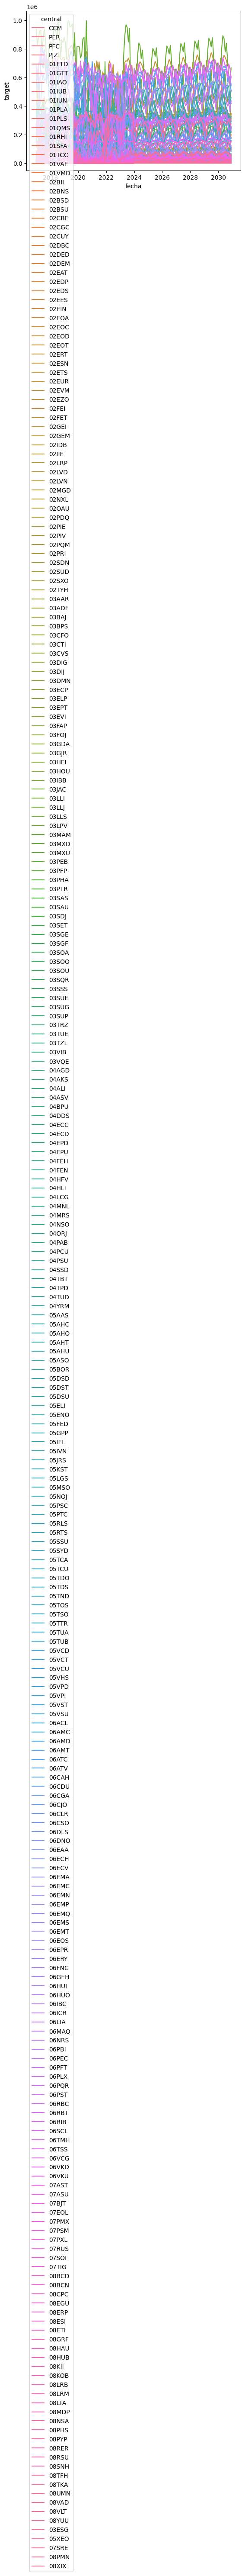

In [141]:
# #plt.plot(y, label='monto', color='green')
# plt.plot(y, label='monto', color='blue')
# plt.plot(y_pred, label= 'monto estimado LP', color='red')
# #plt.plot(y_pred_lp, label= 'monto estimado LP', color='yellow')

# #add legend
# plt.legend(title='Serie')
# plt.title(f'Estimación de montos netos')
# plt.xlabel(f'Periodo')
# plt.ylabel(f'$')


#df_all = df_all.sort_values(by=[['central', 'fecha']], ascending=True)
sns.lineplot(data=df_all, x="fecha", y="target", hue="central")


# Exportar datos a Excel

In [142]:

y_pred_lp['R2'] = results.rsquared_overall
y_pred_lp['MODELO'] = tipo_modelo

y_pred_lp.to_excel(f'/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/Estimaciones_LP/estimaciones_LP_{target}.xlsx')




In [143]:
# df_all['R2'] = results.rsquared_overall
# df_all['MODELO'] = tipo_modelo

# df_all.to_excel(f'/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/Estimaciones_LP/estimaciones_LP_{target}_serie_completa.xlsx')